In [1]:
%load_ext autoreload
%autoreload 2

RANDOM_STATE = 2025

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [3]:
dataset_dir = "../data/cloth_dataset"
csv_file_name = "aarong_dataset_clean_final.csv"

# Load CSV File
csv_file = os.path.join(dataset_dir, csv_file_name)
df = pd.read_csv(csv_file)

df.sample(3)

,product_id,annotated_image_name,fabric_types_clean,wear_types_clean,colors_clean,textures_clean,value_additions_clean
1690,2616,1420000168537.jpg,Viscose,Shalwar Kameez,"black,pink,golden","dobby,screen print",NaN
417,390,0560000071005_2.jpg,Cotton,Saree,"blue,white,green",block print,NaN
2301,7460,0410000101420_t.jpg___upper.png,Viscose Blend,Coats & Jackets,white,screen print,NaN


In [4]:
single_label_features = ['fabric_types_clean', 'wear_types_clean']
multilabel_features = ['colors_clean', 'textures_clean', 'value_additions_clean']

Let's repeat the preprcessing steps to remove NaN values and removing rare labels, as was done in the `training_dataset_review.ipynb` notebook. I will avoid elaborate description for these steps as they are already described in the other notebook.

In [5]:
from my_utils.dataset_utils import remove_rare_labels

for column in single_label_features + multilabel_features:
	# Replace NaN values with empty strings
	df[column] = df[column].fillna('')

	# Remove rare labels
	df[column] = remove_rare_labels(df[column], min_samples_threshold=50)

df.sample(3)

,product_id,annotated_image_name,fabric_types_clean,wear_types_clean,colors_clean,textures_clean,value_additions_clean
301,6886,0570000124362_1.jpg,Viscose Blend,Panjabi,"grey,pink","block print,textured",
1869,7281,0570000120842_1.jpg,Voile,Panjabi,"blue,cyan",block print,
1483,6580,0570000115144.jpg,Viscose,Panjabi,"orange,brown",block print,


Now let's encode the feature labels into one-hot format. For the multi-label features, I will use MultiLabelBinarizer from sklearn, which essentially is a one-hot encoding for multiple labels.

I have implemented two utility functions to do the onehot and mlb encoding, to make it easy to reuse, will import and use them for encoding.

In [6]:
from my_utils.preprocessing_utils import ml_binarizer, onehot_encode

for column_name in single_label_features:
	df = onehot_encode(df, column_name)

for column_name in multilabel_features:
	df = ml_binarizer(df, column_name)

df.sample(3)

,product_id,annotated_image_name,fabric_types_clean,wear_types_clean,colors_clean,textures_clean,value_additions_clean,fabric_types_clean__Cotton,fabric_types_clean__Linen,fabric_types_clean__Muslin,...,textures_clean__wax dye,value_additions_clean__,value_additions_clean__applique,value_additions_clean__fringe,value_additions_clean__handloom,value_additions_clean__lace,value_additions_clean__nakshi,value_additions_clean__sequins,value_additions_clean__tangail,value_additions_clean__tassels
361,1929,0540000021963_1.jpg,Silk,Saree,"red,black,golden",,tangail,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2897,2850,1420000169050.jpg,Viscose Blend,Shalwar Kameez,"brown,pink","dobby,tie dye,embroidery,printed",,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3015,7442,0410000104320.jpg,Cotton,,green,embroidery,,1.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0


At this point, let's create a Train/Validation/Test Split. 70% of the data will be used for training, 15% for validation, and 15% for testing.

In [7]:
from sklearn.model_selection import train_test_split

train_df, val_test_df = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=RANDOM_STATE)


Now let's create a custom dataset that will use the dataframes above and load respective images.

As a first step, I will define a transform function that will be used to preprocess the images.

In [8]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


Now let's define the custom dataset class. This will identify the one-hot encoded label columns, separately for each feature, based on the column prefix. The images will be loaded based on the image file name available in the dataframe.

In [9]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class CustomMTLDataset(Dataset):
	def __init__(self, df, image_dir, transform=None):
		self.df = df.reset_index(drop=True)
		self.image_dir = image_dir
		self.transform = transform

		# Specifying label groups for each classification head
		self.label_columns = {
			'fabric': [col for col in df.columns if col.startswith('fabric_types_clean__')],
			'wear': [col for col in df.columns if col.startswith('wear_types_clean__')],
			'color': [col for col in df.columns if col.startswith('colors_clean__')],
			'texture': [col for col in df.columns if col.startswith('textures_clean__')],
			'value_add': [col for col in df.columns if col.startswith('value_additions_clean__')],
		}

	def __len__(self):
		return len(self.df)

	def __getitem__(self, idx):
		row = self.df.iloc[idx]
		
		image_path = f"{self.image_dir}/{row['annotated_image_name']}"
		image = Image.open(image_path).convert("RGB")
		
		if self.transform:
			image = self.transform(image)

		# Extract labels for each separate task
		labels = {
			task: torch.tensor(row[self.label_columns[task]].values.astype('float32'))
			for task in self.label_columns
		}

		return image, labels


At this point, let's create the data loader using the custom dataset that was just defined. For now, I will use a batch size of 8 as some labels may have very few samples. Will later experiment with larger batch sizes if make sense.



In [10]:
from torch.utils.data import DataLoader

train_ds = CustomMTLDataset(train_df, os.path.join(dataset_dir, 'images'), transform=transform)
val_ds = CustomMTLDataset(val_df, os.path.join(dataset_dir, 'images'), transform=transform)
test_ds = CustomMTLDataset(test_df, os.path.join(dataset_dir, 'images'), transform=transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True) 
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

Now time to build the model. I will use a pre-trained ResNet (resnet 18) model and add a single layer for each (task) classification head on top of it.

I would not freeze backbone weights so they should be trained as well, i.e.- fine-tuning as opposed to feature extraction.

In [11]:
import torch.nn as nn
import torchvision.models as models

class MTLModel(nn.Module):
    def __init__(self, fabric_dim, wear_dim, color_dim, texture_dim, value_add_dim):
        super(MTLModel, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.shared_dim = 512  # Output of resnet18 without FC

        self.heads = nn.ModuleDict({
            'fabric': nn.Linear(self.shared_dim, fabric_dim),
            'wear': nn.Linear(self.shared_dim, wear_dim),
            'color': nn.Linear(self.shared_dim, color_dim),
            'texture': nn.Linear(self.shared_dim, texture_dim),
            'value_add': nn.Linear(self.shared_dim, value_add_dim),
        })

    def forward(self, x):
        features = self.backbone(x)
        return {task: head(features) for task, head in self.heads.items()}


Now let's train the model.

I will use a relatively simple training setup with no learning rate scheduling, class weight consideration or focal loss etc. I will later experiment with these techniques if time permits.

For calculating the training loss, I will use binary cross-entropy with logits for all tasks, for now. In a later experiment, I will try with separate loss functions for single-label and multi-label tasks.

For evaluation, I will use F1 score, precision and recall for multi-label tasks, and accuracy for single-label tasks.

In [12]:
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tqdm import tqdm

def run_epoch(model, loader, optimizer, device, is_train=True, threshold=0.5):
	if is_train:
		model.train()
	else:
		model.eval()

	total_loss = 0.0
	all_preds = {k: [] for k in model.heads}
	all_targets = {k: [] for k in model.heads}

	for images, labels in tqdm(loader):
		images = images.to(device)
		labels = {k: v.to(device) for k, v in labels.items()}

		if is_train:
			optimizer.zero_grad()

		with torch.set_grad_enabled(is_train):
			outputs = model(images)
			losses = []

			for task in outputs:
				loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs[task], labels[task])
				losses.append(loss)

				if not is_train:
					probs = torch.sigmoid(outputs[task])
					preds = (probs > threshold).int()
					all_preds[task].extend(preds.cpu().numpy())
					all_targets[task].extend(labels[task].cpu().numpy())

			batch_loss = sum(losses)
			total_loss += batch_loss.item()

			if is_train:
				batch_loss.backward()
				optimizer.step()

	avg_loss = total_loss / len(loader)

	if not is_train:
		metrics = {
			task: {
				'f1': f1_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'precision': precision_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'recall': recall_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'accuracy': accuracy_score(all_targets[task], all_preds[task])
			}
			for task in all_preds
		}
		return avg_loss, metrics
	else:
		return avg_loss


def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=10, threshold=0.5, verbose=True):
	model.to(device)
	best_val_loss = float('inf')
	patience = 3
	patience_counter = 0

	history = {
		'train_loss': [],
		'val_loss': [],
		'val_metrics': []
	}

	for epoch in range(num_epochs):
		print(f"\nEpoch {epoch+1}/{num_epochs}")
		train_loss = run_epoch(model, train_loader, optimizer, device, is_train=True)
		val_loss, val_metrics = run_epoch(model, val_loader, optimizer, device, is_train=False, threshold=threshold)

		history['train_loss'].append(train_loss)
		history['val_loss'].append(val_loss)
		history['val_metrics'].append(val_metrics)

		print(f"Train Loss: {train_loss:.4f}")
		print(f"Val Loss: {val_loss:.4f}")

		if verbose:
			for task, task_metrics in val_metrics.items():
				print("Metrics for task:", task)
				for metric_name, metric_value in task_metrics.items():
					print(f"\t[Val {metric_name}]: {metric_value:.4f}")

		# Early stopping
		if val_loss < best_val_loss:
			best_val_loss = val_loss
			patience_counter = 0
			torch.save(model.state_dict(), '../data/model_weights/best_model_resnet18.pt')
		else:
			patience_counter += 1
			if patience_counter >= patience:
				print("Early stopping triggered.")

				return history
				#break

	return history


In [13]:
model = MTLModel(
	fabric_dim=len(train_ds.label_columns['fabric']),
	wear_dim=len(train_ds.label_columns['wear']),
	color_dim=len(train_ds.label_columns['color']),
	texture_dim=len(train_ds.label_columns['texture']),
	value_add_dim=len(train_ds.label_columns['value_add']),
)

for param in model.backbone.parameters():
	param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    threshold=0.5,
	verbose=False
)



Epoch 1/10


  0%|          | 0/289 [00:00<?, ?it/s]

100%|██████████| 62/62 [00:03<00:00, 16.66it/s]


Train Loss: 1.4656
Val Loss: 1.3626

Epoch 2/10


100%|██████████| 62/62 [00:03<00:00, 17.14it/s]


Train Loss: 1.3052
Val Loss: 1.2470

Epoch 3/10


100%|██████████| 62/62 [00:03<00:00, 18.09it/s]


Train Loss: 1.2213
Val Loss: 1.1719

Epoch 4/10


100%|██████████| 62/62 [00:03<00:00, 18.13it/s]


Train Loss: 1.1679
Val Loss: 1.1722

Epoch 5/10


100%|██████████| 62/62 [00:03<00:00, 18.05it/s]


Train Loss: 1.1060
Val Loss: 1.1483

Epoch 6/10


100%|██████████| 62/62 [00:03<00:00, 18.20it/s]


Train Loss: 1.0626
Val Loss: 1.1218

Epoch 7/10


100%|██████████| 62/62 [00:03<00:00, 17.97it/s]


Train Loss: 1.0201
Val Loss: 1.1606

Epoch 8/10


100%|██████████| 62/62 [00:03<00:00, 17.13it/s]


Train Loss: 0.9457
Val Loss: 1.1409

Epoch 9/10


100%|██████████| 62/62 [00:03<00:00, 16.75it/s]

Train Loss: 0.8727
Val Loss: 1.1795
Early stopping triggered.


Let's plot the training and validation loss first. And then look at the evaluation metrics for each task.

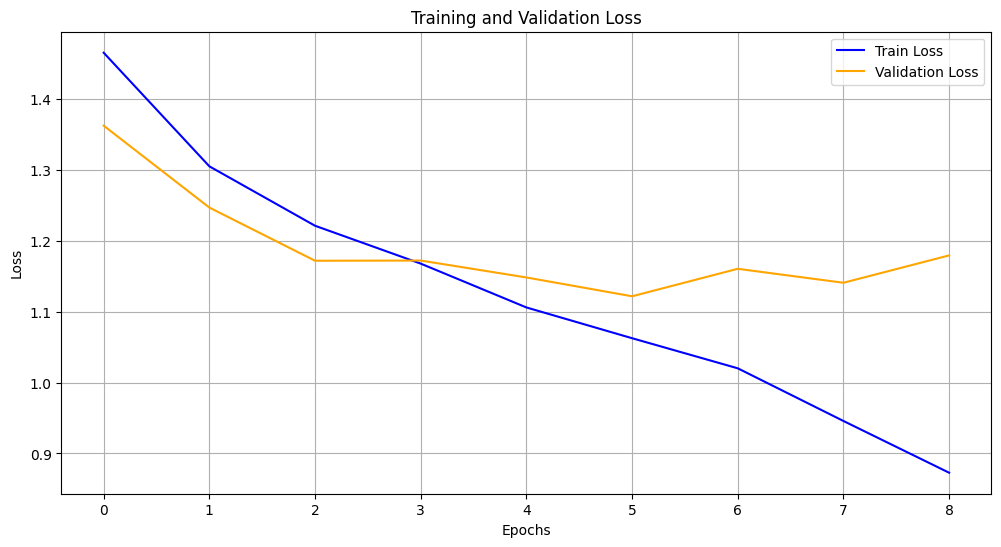

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


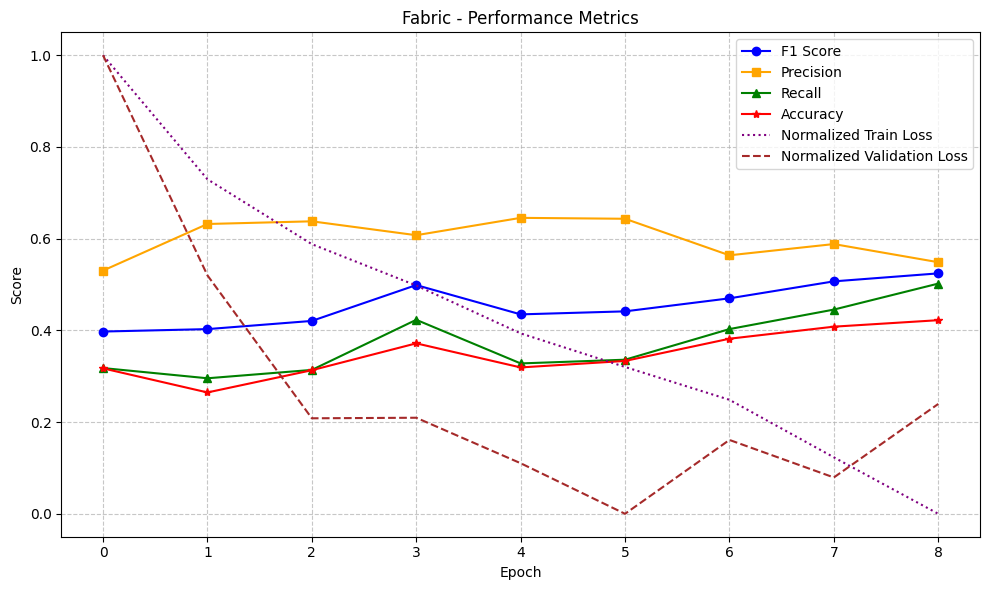

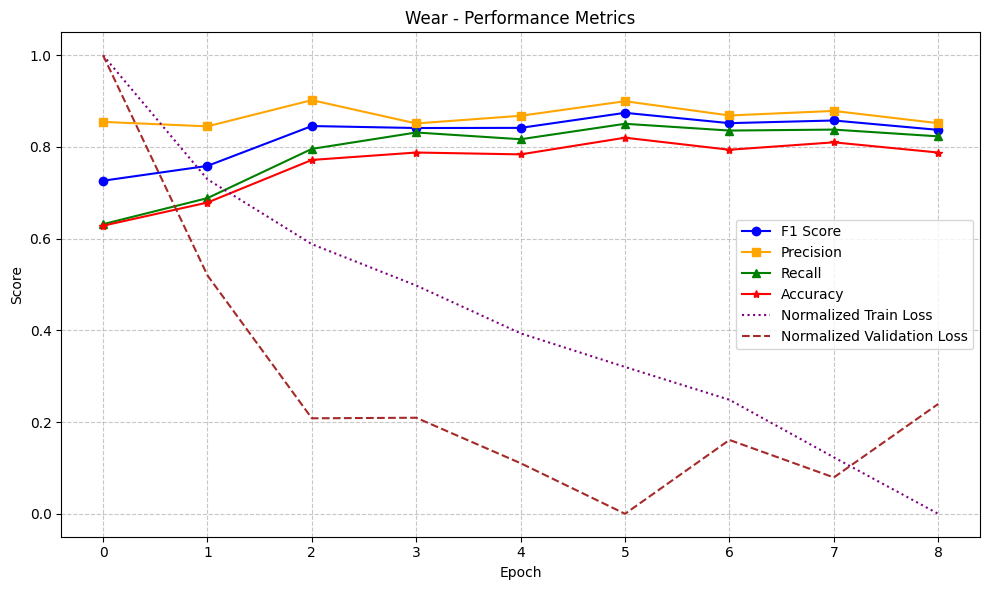

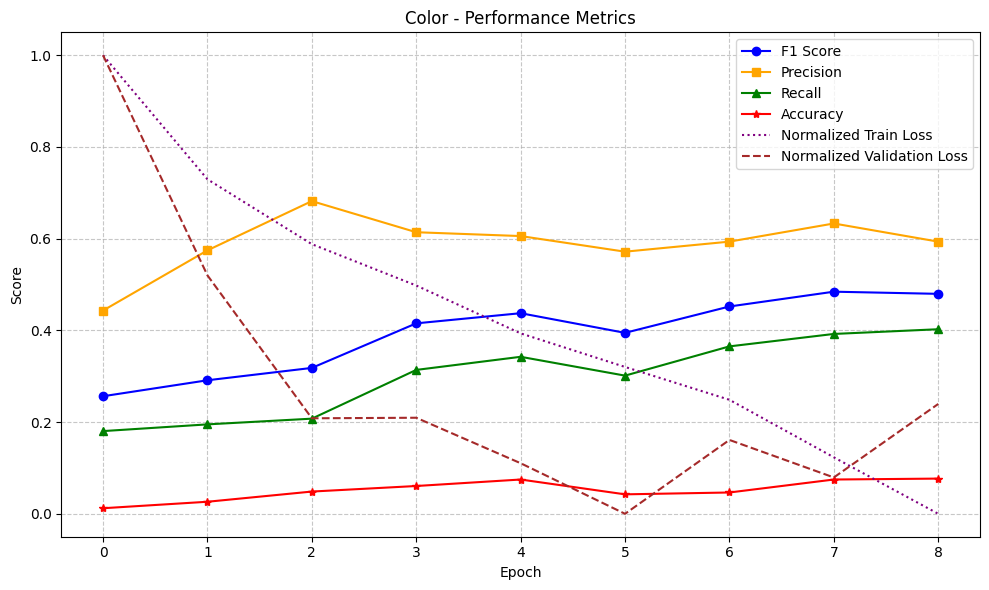

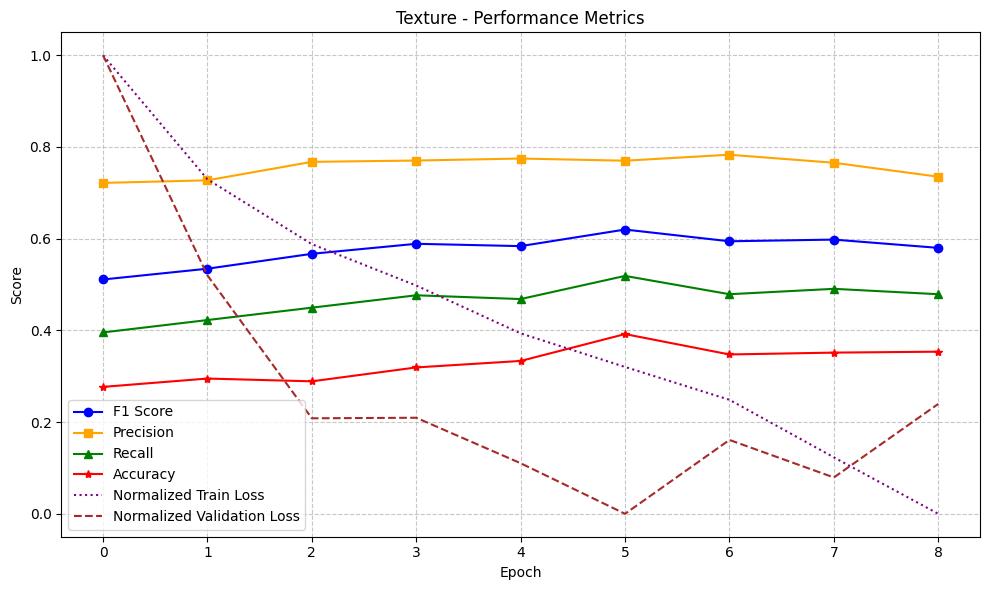

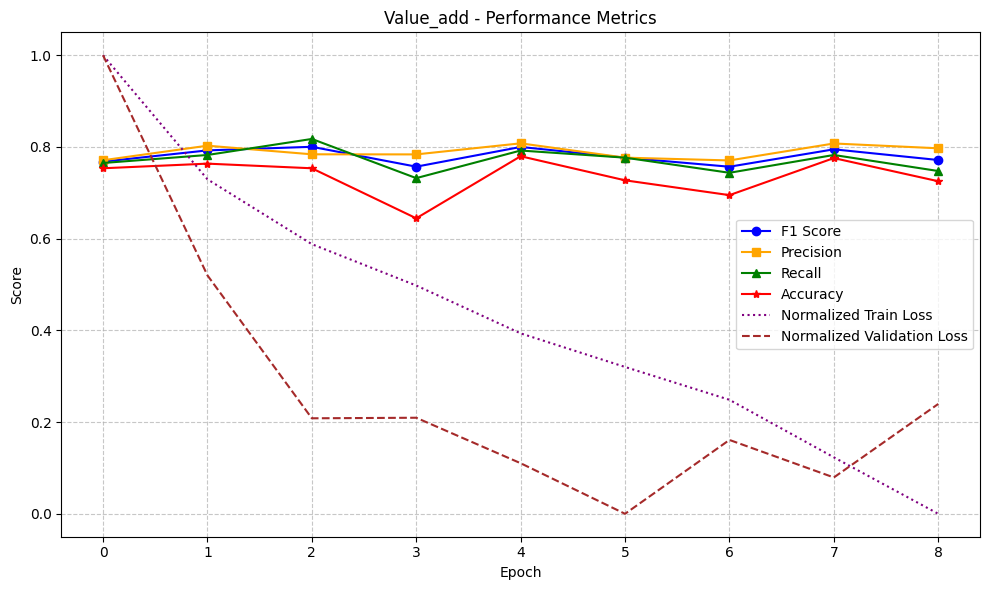

In [16]:
def plot_task_performance(history, task, show_training_loss=False, show_validation_loss=False):
	# Extract metrics for the specified task
	f1_scores = [epoch_metrics[task]['f1'] for epoch_metrics in history['val_metrics']]
	precision_scores = [epoch_metrics[task]['precision'] for epoch_metrics in history['val_metrics']]
	recall_scores = [epoch_metrics[task]['recall'] for epoch_metrics in history['val_metrics']]
	accuracy_scores = [epoch_metrics[task]['accuracy'] for epoch_metrics in history['val_metrics']]
	
	# Create figure
	plt.figure(figsize=(10, 6))
	
	# Plot all metrics in a single plot
	plt.plot(f1_scores, label='F1 Score', color='blue', marker='o')
	plt.plot(precision_scores, label='Precision', color='orange', marker='s')
	plt.plot(recall_scores, label='Recall', color='green', marker='^')
	plt.plot(accuracy_scores, label='Accuracy', color='red', marker='*')

	if show_training_loss:
		normalized_train_loss = [(loss - min(history['train_loss'])) / (max(history['train_loss']) - min(history['train_loss'])) for loss in history['train_loss']]
		plt.plot(normalized_train_loss, label='Normalized Train Loss', color='purple', linestyle=':')
	if show_validation_loss:
		normalized_val_loss = [(loss - min(history['val_loss'])) / (max(history['val_loss']) - min(history['val_loss'])) for loss in history['val_loss']]
		plt.plot(normalized_val_loss, label='Normalized Validation Loss', color='brown', linestyle='--')
	
	plt.title(f'{task.capitalize()} - Performance Metrics')
	plt.xlabel('Epoch')
	plt.ylabel('Score')
	plt.legend()
	plt.grid(True, linestyle='--', alpha=0.7)
	plt.tight_layout()
	plt.show()

plot_task_performance(history, 'fabric', True, True)
plot_task_performance(history, 'wear', True, True)
plot_task_performance(history, 'color', True, True)
plot_task_performance(history, 'texture', True, True)
plot_task_performance(history, 'value_add', True, True)

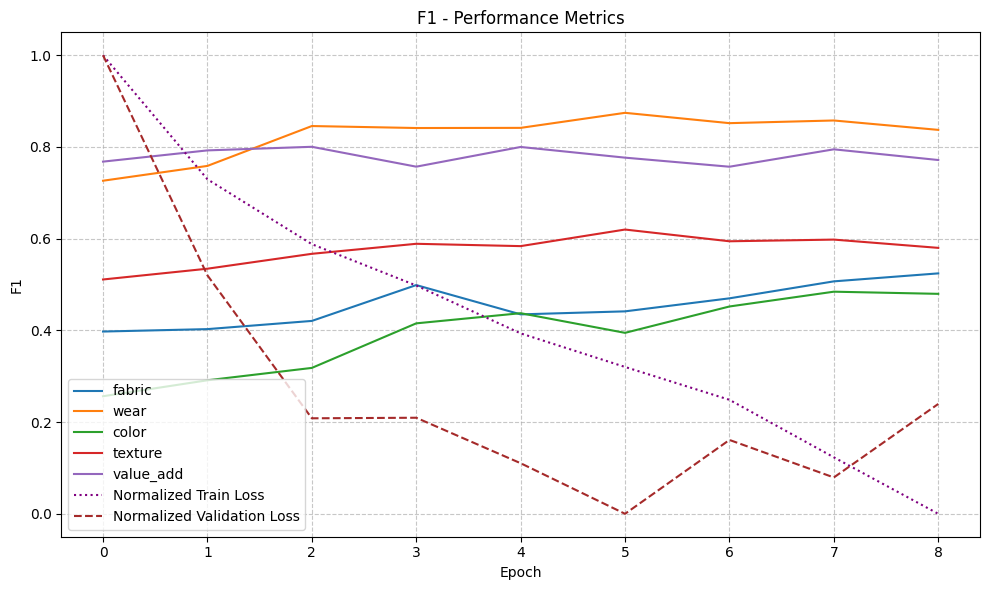

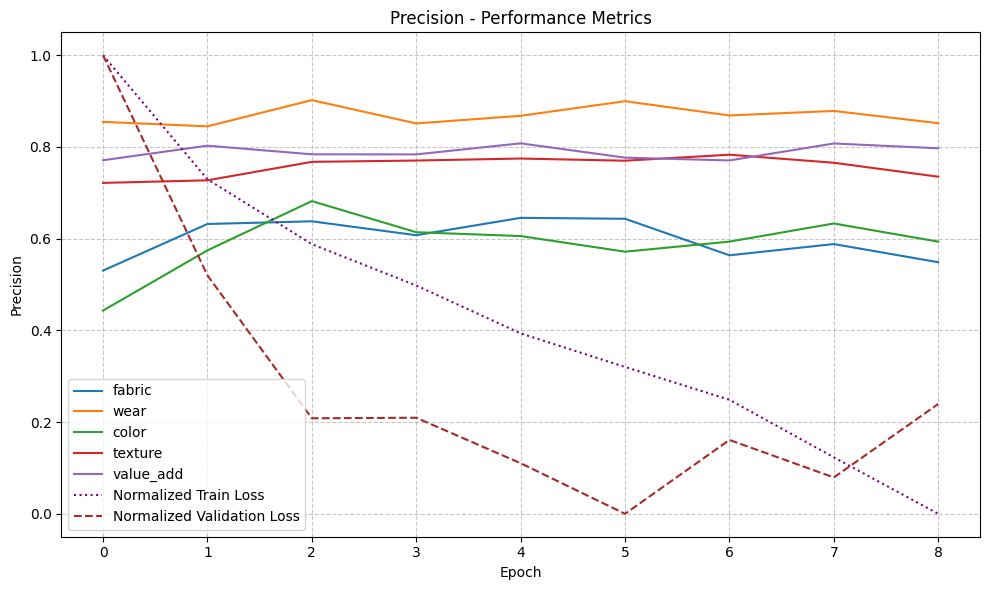

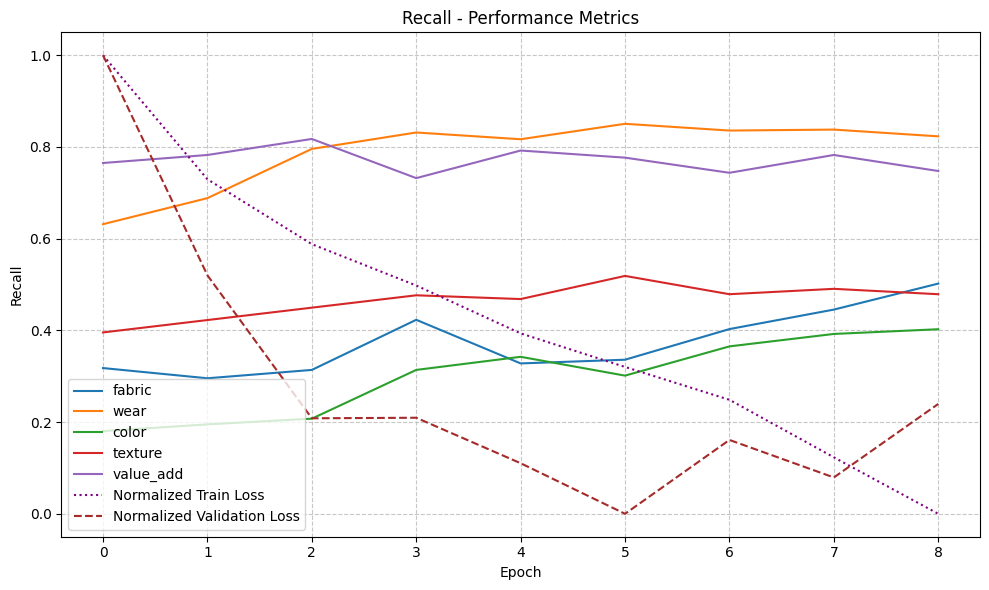

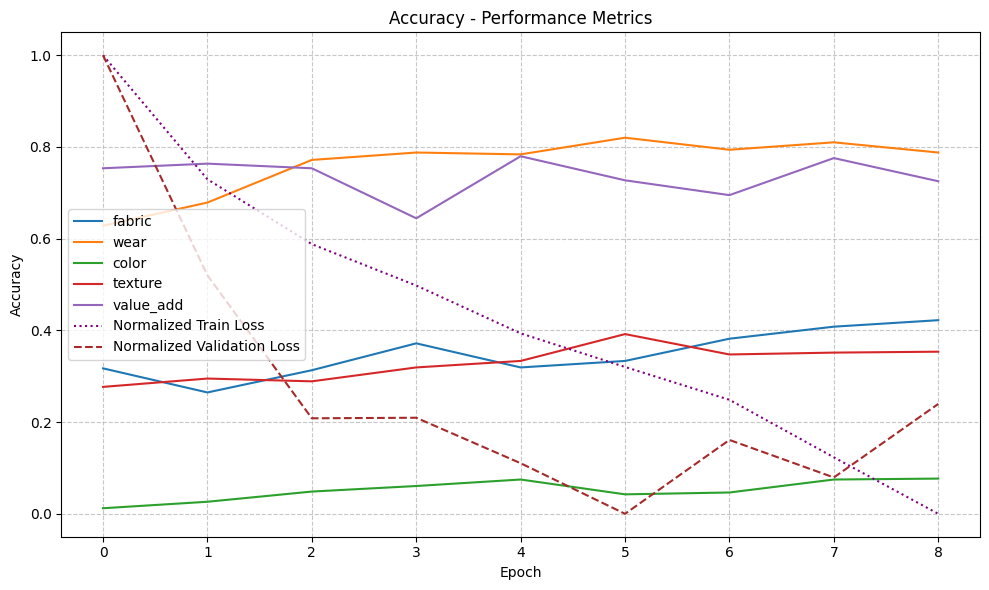

In [17]:
def compare_tasks(history, metric_name, show_training_loss=False, show_validation_loss=False):
	plt.figure(figsize=(10, 6))

	tasks = history['val_metrics'][0].keys()

	for task in tasks:
		# Extract specific metric for the task
		metric_scores = [epoch_metrics[task][metric_name] for epoch_metrics in history['val_metrics']]
		plt.plot(metric_scores, label=task)

	if show_training_loss:
		normalized_train_loss = [(loss - min(history['train_loss'])) / (max(history['train_loss']) - min(history['train_loss'])) for loss in history['train_loss']]
		plt.plot(normalized_train_loss, label='Normalized Train Loss', color='purple', linestyle=':')
	if show_validation_loss:
		normalized_val_loss = [(loss - min(history['val_loss'])) / (max(history['val_loss']) - min(history['val_loss'])) for loss in history['val_loss']]
		plt.plot(normalized_val_loss, label='Normalized Validation Loss', color='brown', linestyle='--')
	
	plt.title(f'{metric_name.capitalize()} - Performance Metrics')
	plt.xlabel('Epoch')
	plt.ylabel(metric_name.capitalize())
	plt.legend()
	plt.grid(True, linestyle='--', alpha=0.7)
	plt.tight_layout()
	plt.show()

compare_tasks(history, 'f1', True, True)
compare_tasks(history, 'precision', True, True)
compare_tasks(history, 'recall', True, True)
compare_tasks(history, 'accuracy', True, True)

This is end of initial experiments. Addional experiments will be done in separate notebook so that the experiments are cleaner and easy to follow, most pre-processing and utility functions will be moved to a separate module and reused in the rest of the notebooks.